In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 38.5MB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os

In [4]:
from google.colab import drive

In [6]:
from konlpy.tag import Okt
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import FastText
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

- 한국어 사전학습 임베딩(ko.bin) 로드

In [9]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/Natural_Language_Processing/data/ko.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/data/ko.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


In [11]:
kovec = Word2Vec.load('ko.bin')

## 1. 함수정의

### 1) 전처리 함수

In [28]:
okt = Okt()
def preprocess_sentences(sentences):
  sentences = sent_tokenize(sentences)
  return [preprocess_sentence(sentence) for sentence in sentences]

In [29]:
def preprocess_sentence(sentence):
  sentence = re.sub(r'[^가-힣A-Za-z0-9]', ' ', sentence)
  sentence = okt.morphs(sentence, stem = True)
  return [word for word in sentence if word not in stopwords]

In [ ]:
def tokenization(sentences):
  return [word_tokenize(sentence) for sentence in sentences]

### 2) 문장 벡터의 평균 구하는 함수 정의

In [15]:
embedding_dim = 200
zero_vector = np.zeros(embedding_dim)

def calculate_sentence_vector(sentence):
  sum = np.zeros(embedding_dim)
  for word in sentence :
    if len(sentence) != 0 and word in kovec.wv.vocab.keys():
      sum += kovec.wv.get_vector(word)
    else : 
      sum += zero_vector

  return sum /len(sentence)

In [16]:
def sentences_to_vectors(sentences) :
  return [calculate_sentence_vector(sentence) for sentence in sentences]

### 3) 문장 벡터간 코사인 유사도 구하는 함수 정의

In [17]:
def similarity_matrix(sentence_embedding) :
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])

  for i in range(len(sentence_embedding)):
    for j in range(len(sentence_embedding)):
      sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                        sentence_embedding[j].reshape(1, embedding_dim))[0,0]
  return sim_mat  

### 4) 유사도 행렬 그래프 그리기

In [18]:
def draw_graphs(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
  plt.show()

### 5) 문장 간 유사도 점수 구하기

In [19]:
def calculate_score(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(nx_graph)
  return scores

In [20]:
# 리스트 flatten 함수 정의
def flat_list(array): 
  a=[]
  for i in array:
    if type(i) == type(list()):
      a+=(flat_list(i))
    else:
      a.append(i)
  return a

### 6) 유사도 상위 문장 추출 함수 정의

In [21]:
def ranked_sentences(sentences, scores, n=3):
  top_scores = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
  top_n_sentences = [sentence for score,sentence in top_scores[:n]]
  top_n_sentences = flat_list(top_n_sentences)
  return " ".join(top_n_sentences)

## 2. 문장 적용

- 요약할 원문

In [12]:
sentences = '''이곳은 별로 크지 않고, 깔끔하지도 않은 극장이다. 어딜 가더라도 눅눅한 냄새가 느껴지는 극장이다. 그렇지만, 나는 다른 극장보다 천 원이 싸고, 사람들이 얼마 없는데다가 극장 앞 노점에서 파는 문어 다리가 맛있다는 이유로 이 극장에 자주 온다. 극장 안은 고양이가 쥐를 모두 잡아먹은 후의 쥐구멍 속처럼 조용하지만, 노점들이 가득한 극장 앞 거리는 지나다니는 보행자들로 가득 차 있다. 극장 바깥에서 담배 한 대 피우기가 민망할 정도로 사람이 많이 지나다닌다. 게다가 까만 옷, 하얀 옷을 입은 사람들은 다리가 보이지 않는 속도로 걸어간다. 
  
    사람들을 바라보면서 혼자 중얼거린다. “왜 저 인간들은 이 극장 놔두고, CGV니 메가박스니 하는 정신 없는 극장에 가는 걸까? 그리고 뭐 저리들 바쁜 걸까?” 모두가 “상대적인 거니까.”라는 절대적인 답을 하리란 걸 아는 나는 스스로 답하는 것 따위에는 관심이 없다. 이 질문은 그저 ‘나는 내 세상이 있어’라는 자만심 가득한 말을 에둘러 표현한 것에 불과하다고 반성을 한다. 그리고 말한다. “머리가 아프다, 이런 생각을 하니까.” 나는 사람 구경이나 더 할 요량으로, 복도에서 건물 바깥으로 나간다. 
  
    입구 계단에 앉아서 인상을 잔뜩 찌푸린 한 남자가 보인다. 그 옆에는 담배 필터를 씹어대는 한 여자가 있다. 둘이 감정 없는 목소리로 나누는 인사 소리가 들려온다. “안녕하세요.” 그리고 이어지는 “예에.” 나는 아주 작은 목소리로 “저따위 목소리로 인사할 바에야, 그냥 모르는 체 하겠다. 차가운 인간들.”이라고 그들의 대화 뒤에 내 말을 친절하게 덧붙인다. 사람들의 대화라는 일종의 상차림에다가 내 말을 하나 올려 놓고 싶을 뿐이다. 그냥 내가 외로우니까.
  
    남자가 극장 안으로 다시 들어간다. 나도 따라 들어간다. “저 사람, 괜히 마음에 든다.”고 중얼거려본다. 까칠한 말동무가 필요한 날이다. 이 극장에 오는 몇 안 되는 사람들 중에 까칠한 사람을 발견한다는 건 드문 일이다. 내가 꼬리에 꼬리를 물고 끄집어 내는 머리 속의 생각들을 찬찬히 살펴 보면, 내게는 까칠한 사람들이 어울린다. 까칠하고 말 잘라먹기 좋아하는 외계인들은 빌어먹지도 못 할 잰 체하는 마초보다야 1000 배는 낫고, 긴장해서 말을 더듬는 숙맥보다는 43배 정도 낫다. 상영관으로 따라 들어간다. 그리고 남자의 옆의 옆 자리에 앉는다. 문어 다리를 씹다가, 남자에게 문어 다리 몇 개를 건네며 수다쟁이처럼 말한다. “웃으실 때, 담배 냄새 풍겨요. 문어 다리 하나 드세요. 아, 장난이에요. 아줌마가 문어다리를 너무 많이 줬네요. 조금 드세요. 더 먹고 싶으면 말씀하시고요.” 남자는 문어 다리를 받아 들고 “고맙네요. 담배 냄새나, 문어 다리 냄새나 뭐.”라고 말한다. 영화가 시작할 즈음, 남자는 조용히 문어를 씹기 시작한다. 
  
    영화를 보는 내내, 쥐 구멍 속에서 바깥으로 나가기는 싫지만, 구멍 안에서 다른 쥐랑 같이 있자니 불편해 죽을 것 같은 쥐새끼 같은 마음 상태다. 남자는 문어 다리를 씹는 것 말고는 눈길 한 번 주지 않고, 영화는 지루한데다가, 꼬리에 꼬리를 물고 떠오르는 온갖 잡생각들 때문에 나한테 짜증이 난다. 결국 “문어 다리도 혼자서나 씹자. 사람 구경은 해서 뭐하니, 아까 담배나 피우고 들어올 걸 그랬다. 듣지도 않는 말이나 떠들고, 나는 글러먹은 사람이다.”라고 투덜대며 영화가 미처 끝나지도 않았지만, 상영관을 빠져 나온다. 
  
    "차라리 CGV에나 가서 쁘띠 부르주아지 놀이나 할 걸 그랬나? 지저분한 극장에 들어갔더니 젠장 할 내 머리만 복잡해진다.” 노점이 가득한 인도 끝자락에 서서 중얼거린다. “아, 지랄 맞다. 나 정말 글러먹은 인간이야.” 아까 문어 다리를 산 노점 아줌마가 내게 말한다. “정신 차려. 호랑이한테 잡혀갈라. 어흥.” 나는 허하게 웃는다. '''

### 1) 전처리

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
stopwords = ['의', '가', '이', '은', '들', '는',
             '좀', '잘', '걍', '과', '도',
             '를', '으로', '자', '에', '와', '한', '하다']

In [30]:
sentences = preprocess_sentences(sentences)

### 2) 문장 벡터 평균 구하기

In [31]:
sentence_embedding = sentences_to_vectors(sentences)

### 3) 문장 벡터들 간 코사인 유사도 구하기

In [32]:
sim_matrix = similarity_matrix(sentence_embedding)

### 4) 유사도 행렬 그래프

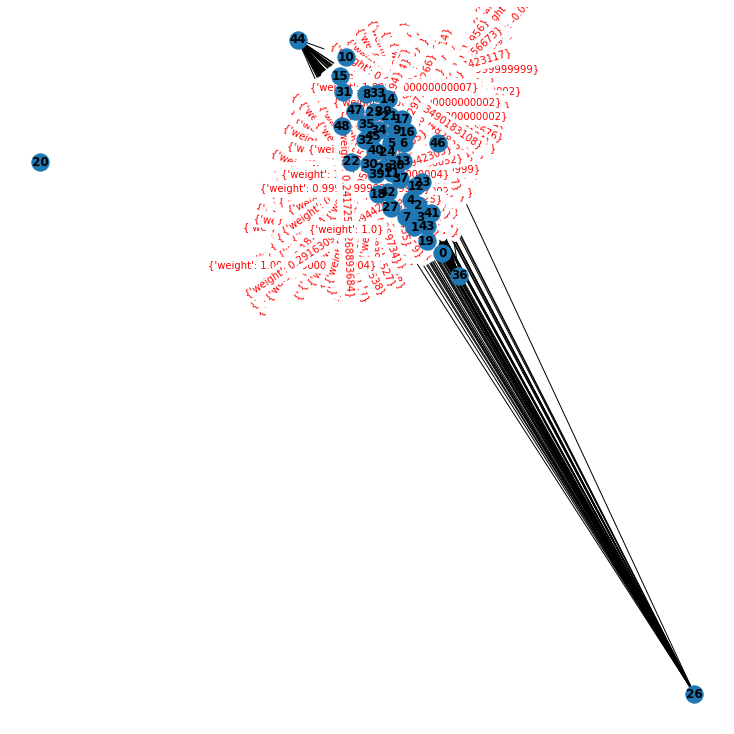

In [33]:
draw_graphs(sim_matrix)

### 5) 각 문장 점수 계산 후 요약문 추출

In [34]:
scores = calculate_score(sim_matrix)
ranked_sentences(sentences, scores, n = 5)

'남자 문어 다리 씹다 것 말고는 눈길 번 주지 않다 영화 지루하다 꼬리 꼬리 물 고 떠오르다 온갖 잡 생각 때문 나 한테 짜증 나다 내 꼬리 꼬리 물 고 끄다 집다 내다 머리 속 생각 을 찬찬하다 살피다 보다 내다 까칠하다 사람 어울리다 영화 보다 내내 쥐 구멍 속 에서 바깥 나가다 싫다 구멍 안 에서 다른 쥐 랑 같이 있다 불편하다 죽 을 것 같다 쥐 새끼 같다 마음 상태 다 나 정말 글러먹 인간 이야 아깝다 문어 다리 산 노점 아줌마 내다 말 담배 냄새 나 문어 다리 냄새 나 뭐 라고 말'